# 基于卫星影像的土地覆盖分类
用U_net解决多类分类的问题

## 数据集
输入数据是RGB卫星图像，输出是土地覆盖类型的图像。有以下4种土地覆盖类型：

- 像素值0：背景类
- 像素值1：建筑类
- 像素值2：植被/森林类
- 像素值3：水域类

**数据已经被随机化并分割成训练集和测试集。因此，我们可以直接使用它们。**

## 导入包

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

## 导入数据
**数据已经被随机化并分割成训练集和测试集。因此，我们可以直接使用它们。**



In [2]:
x_train = np.load('../data/land_use_image/x_train.npy').astype('float32')
y_train= np.load('../data/land_use_image/y_train.npy').astype('float32')
x_test = np.load('../data/land_use_image/x_test.npy').astype('float32')
y_test = np.load('../data/land_use_image/y_test.npy').astype('float32') 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


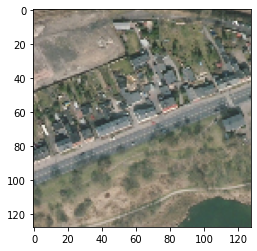

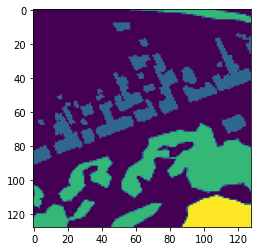

In [3]:
# 绘制一个样本输入的RGB图像和带有土地覆盖的输出图像。

plt.imshow(x_test[12,:,:,:].astype('uint8'))
plt.show()

plt.imshow(y_test[12,:,:,0].astype('uint8'))
plt.show()

由于土地覆盖数据包含多个类别，让执行one-hot编码。



In [4]:
'''one-hot encoding'''

from tensorflow.keras.utils import to_categorical

y_train_1hot = to_categorical(y_train)
y_test_1hot = to_categorical(y_test)

y_train_1hot.shape

(70, 128, 128, 4)

现在，让我们来定义、拟合、预测和验证U-Net模型，用于土地覆盖类型映射。在这个例子中，我们将使用与上一个例子（建筑物映射）相同的U-Net架构。唯一的不同之处在于，在最后一层使用了`softmax`激活函数，并且使用了`categorical-cross-entrop`交叉熵损失，因为这是一个多类分类问题。

# U-net模型

In [5]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)

x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)

x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)

x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])

x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])

x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])

x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''多类分类问题应该使用softmax激活函数'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(4, (1, 1), activation='softmax', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)


model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [6]:
history = model.fit(x_train, y_train_1hot, validation_data=(x_test, y_test_1hot), epochs=250, batch_size=8, verbose=1)

Epoch 1/250
9/9 [==============================] - 13s 221ms/step - loss: 3.4788 - val_loss: 1.1065
Epoch 2/250
9/9 [==============================] - 1s 69ms/step - loss: 1.0435 - val_loss: 1.0606
Epoch 3/250
9/9 [==============================] - 1s 71ms/step - loss: 0.9051 - val_loss: 1.0181
Epoch 4/250
9/9 [==============================] - 1s 66ms/step - loss: 0.8635 - val_loss: 1.0995
Epoch 5/250
9/9 [==============================] - 1s 72ms/step - loss: 0.8376 - val_loss: 1.0163
Epoch 6/250
9/9 [==============================] - 1s 68ms/step - loss: 0.7953 - val_loss: 0.8706
Epoch 7/250
9/9 [==============================] - 1s 70ms/step - loss: 0.7660 - val_loss: 0.9962
Epoch 8/250
9/9 [==============================] - 1s 72ms/step - loss: 0.7716 - val_loss: 1.0251
Epoch 9/250
9/9 [==============================] - 1s 70ms/step - loss: 0.7721 - val_loss: 0.8735
Epoch 10/250
9/9 [==============================] - 1s 71ms/step - loss: 0.7360 - val_loss: 0.7351
Epoch 11/250
9/9 

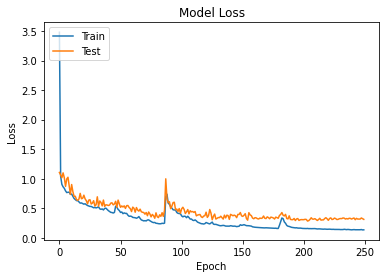

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()